In [1]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from gudhi import SimplexTree
from matplotlib import pyplot as plt

import pandas as pd

In [2]:
class GluedVoronoiComplex:
    def __init__(self, points, glue={}):
        """
        """
        self.points = np.array(points)
        self.glue = glue
    
    def get_vertices(self):
        """
        """
        self.points_copies = {}
        self.points_additional = []
        for a, b in self.glue.keys():
            point_ab = self.points[a] + self.glue[(a, b)]
            point_ba = self.points[b] - self.glue[(a, b)]
            self.points_additional.append(point_ab)
            self.points_additional.append(point_ba)
            try:
                self.points_copies[a].append(point_ba)
            except KeyError:
                self.points_copies.update({a : [point_ba]})
            try:
                self.points_copies[b].append(point_ab)
            except KeyError:
                self.points_copies.update({b : [point_ab]})
        self.points_additional = np.array(self.points_additional)
        self.points_additional = np.unique(self.points_additional, axis=0)
        points_all = np.concatenate([self.points, self.points_additional])
        self.vor = Voronoi(points_all)
        
        if (self.vor.points != points_all).any():
            msg = 'Нужно всё-таки с функциями реиндексации изъёбываться\n'
            msg += 'В резульате работы конструктора Voronoi по итогу порядок точек в Voronoi.points '
            msg += 'не совпадает c порядком точек в аргументе кнструктора points.'
            raise IndexError(msg)
        
        pass

In [3]:
def get_A2_on_torus(n):
    """
    """
    if n % 2 != 0:
        raise ValueError('n should be odd')
    basis = np.array([[1, 0], [-0.5, 0.5*3**0.5]])
    points = np.array([np.tile(np.arange(n), n), np.repeat(np.arange(n), n)]).transpose()
    points += np.array([np.repeat(np.arange(n//2), 2*n), np.zeros(n*n, dtype=int)]).transpose()
    points = points @ basis
    glue = {}
    for pair in np.array([n*np.arange(n) + n - 1, n*np.arange(n)]).transpose():
        glue.update({tuple(pair) : basis[0]})
    for pair in np.array([np.arange(n) + n*n - n, (np.arange(n) - 1)%n]).transpose():
        glue.update({tuple(pair) : basis[1]})
    for pair in np.array([np.arange(n) + n*n - n, np.arange(n)]).transpose():
        glue.update({tuple(pair) : basis[0] + basis[1]})
    
    return points, glue

In [4]:
def get_Z2_on_torus(n, m):
    points = np.array([np.tile(np.arange(n), m), np.repeat(np.arange(m), n)]).transpose()
    glue = {(n*m-1, 0) : np.ones(2, dtype=int), 
            (n*m-n, n-1) : np.array([-1, 1])}
    for i in range(m):
        glue.update({(i*n + n - 1, i*n) : np.array([1, 0])})
    for i in range(n):
        glue.update({((m-1)*n + i, i) : np.array([0, 1])})
    
    return points, glue

In [5]:
points, glue = get_Z2_on_torus(3, 5)
points, glue = get_A2_on_torus(4)
points, glue

(array([[ 0.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 2.        ,  0.        ],
        [ 3.        ,  0.        ],
        [-0.5       ,  0.8660254 ],
        [ 0.5       ,  0.8660254 ],
        [ 1.5       ,  0.8660254 ],
        [ 2.5       ,  0.8660254 ],
        [ 0.        ,  1.73205081],
        [ 1.        ,  1.73205081],
        [ 2.        ,  1.73205081],
        [ 3.        ,  1.73205081],
        [-0.5       ,  2.59807621],
        [ 0.5       ,  2.59807621],
        [ 1.5       ,  2.59807621],
        [ 2.5       ,  2.59807621]]),
 {(3, 0): array([1., 0.]),
  (7, 4): array([1., 0.]),
  (11, 8): array([1., 0.]),
  (15, 12): array([1., 0.]),
  (12, 3): array([-0.5      ,  0.8660254]),
  (13, 0): array([-0.5      ,  0.8660254]),
  (14, 1): array([-0.5      ,  0.8660254]),
  (15, 2): array([-0.5      ,  0.8660254]),
  (12, 0): array([0.5      , 0.8660254]),
  (13, 1): array([0.5      , 0.8660254]),
  (14, 2): array([0.5      , 0.8660254]),
  (15, 3)

In [6]:
g = GluedVoronoiComplex(points=points, glue=glue)
g.get_vertices()

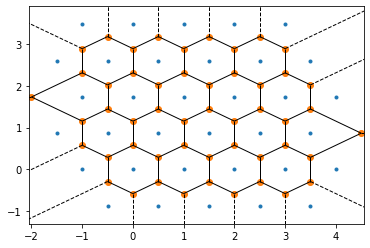

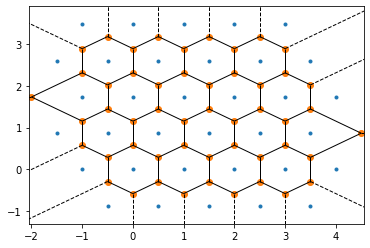

In [7]:
voronoi_plot_2d(g.vor)

In [8]:
pd.DataFrame({'point' : g.vor.point_region, 
              'region' : g.vor.regions[1:]})

,point,region
0,7,"[3, -1, 1, 2]"
1,30,"[9, 5, 6, 7, 8]"
2,28,"[6, -1, 1, 5]"
3,33,"[7, 0, -1, 6]"
4,6,"[17, 13, 14, 12, 15, 16]"
5,5,"[17, 2, 1, 5, 9, 13]"
6,29,"[20, 3, 2, 17, 16, 18]"
7,34,"[22, 8, 9, 13, 14, 21]"
8,8,"[24, 4, 0, 7, 8, 22]"
9,20,"[24, 4, -1, 23]"
